<a href="https://colab.research.google.com/github/begraiPB/BigDataProject/blob/main/Data_255_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Text classification with the torchtext library

In this tutorial, we will show how to use the torchtext library to build the dataset for the text classification analysis. Users will have the flexibility to

   - Access to the raw data as an iterator
   - Build data processing pipeline to convert the raw text strings into ``torch.Tensor`` that can be used to train the model
   - Shuffle and iterate the data with [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)_


## Prerequisites

A recent 2.x version of the ``portalocker`` package needs to be installed prior to running the tutorial.
For example, in the Colab environment, this can be done by adding the following line at the top of the script:

.. code-block:: bash
     
    !pip install -U portalocker>=2.0.0`


In [2]:
!pip install -U portalocker>=2.0.0

### Access to the raw dataset iterators

The torchtext library provides a few raw dataset iterators, which yield the raw text strings. For example, the ``AG_NEWS`` dataset iterators yield the raw data as a tuple of label and text.

To access torchtext datasets, please install torchdata following instructions at https://github.com/pytorch/data.




In [3]:
!pip install torchdata
!pip install torchtext

In [4]:
import torch
import portalocker
from torchtext.datasets import AG_NEWS

train_iter = iter(AG_NEWS(split="train"))

In [5]:
next(train_iter)

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

```sh
next(train_iter)
>>> (3, "Fears for T N pension after talks Unions representing workers at Turner
Newall say they are 'disappointed' after talks with stricken parent firm Federal
Mogul.")

next(train_iter)
>>> (4, "The Race is On: Second Private Team Sets Launch Date for Human
Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\\team of
rocketeers competing for the  #36;10 million Ansari X Prize, a contest
for\\privately funded suborbital space flight, has officially announced
the first\\launch date for its manned rocket.")

next(train_iter)
>>> (4, 'Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded
by a chemistry researcher at the University of Louisville won a grant to develop
a method of producing better peptides, which are short chains of amino acids, the
building blocks of proteins.')
```


### Prepare data processing pipelines

We have revisited the very basic components of the torchtext library, including vocab, word vectors, tokenizer. Those are the basic data processing building blocks for raw text string.

Here is an example for typical NLP data processing with tokenizer and vocabulary. The first step is to build a vocabulary with the raw training dataset. Here we use built in
factory function `build_vocab_from_iterator` which accepts iterator that yield list or iterator of tokens. Users can also pass any special symbols to be added to the
vocabulary.



In [6]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")
train_iter = AG_NEWS(split="train")


def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [8]:
vocab(['here', 'is', 'an', 'example'])

[475, 21, 30, 5297]

The vocabulary block converts a list of tokens into integers.

```sh
vocab(['here', 'is', 'an', 'example'])
>>> [475, 21, 30, 5297]
```
Prepare the text processing pipeline with the tokenizer and vocabulary. The text and label pipelines will be used to process the raw data strings from the dataset iterators.



In [15]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

The text pipeline converts a text string into a list of integers based on the lookup table defined in the vocabulary. The label pipeline converts the label into integers. For example,

```sh
text_pipeline('here is the an example')
>>> [475, 21, 2, 30, 5297]
label_pipeline('10')
>>> 9
```


### Generate data batch and iterator

[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)_
is recommended for PyTorch users (a tutorial is [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)_).
It works with a map-style dataset that implements the ``getitem()`` and ``len()`` protocols, and represents a map from indices/keys to data samples. It also works with an iterable dataset with the shuffle argument of ``False``.

Before sending to the model, ``collate_fn`` function works on a batch of samples generated from ``DataLoader``. The input to ``collate_fn`` is a batch of data with the batch size in ``DataLoader``, and ``collate_fn`` processes them according to the data processing pipelines declared previously. Pay attention here and make sure that ``collate_fn`` is declared as a top level def. This ensures that the function is available in each worker.

In this example, the text entries in the original data batch input are packed into a list and concatenated as a single tensor for the input of ``nn.EmbeddingBag``. The offset is a tensor of delimiters to represent the beginning index of the individual sequence in the text tensor. Label is a tensor saving the labels of individual text entries.



In [16]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)


train_iter = AG_NEWS(split="train")
dataloader = DataLoader(
    train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch
)

### Define the model

The model is composed of the [nn.EmbeddingBag](https://pytorch.org/docs/stable/nn.html?highlight=embeddingbag#torch.nn.EmbeddingBag)_ layer plus a linear layer for the classification purpose. ``nn.EmbeddingBag`` with the default mode of "mean" computes the mean value of a “bag” of embeddings. Although the text entries here have different lengths, ``nn.EmbeddingBag`` module requires no padding here since the text lengths are saved in offsets.

Additionally, since ``nn.EmbeddingBag`` accumulates the average across
the embeddings on the fly, ``nn.EmbeddingBag`` can enhance the
performance and memory efficiency to process a sequence of tensors.

<img src="file://../_static/img/text_sentiment_ngrams_model.png">




In [17]:
from torch import nn


class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

### Initiate an instance

The ``AG_NEWS`` dataset has four labels and therefore the number of classes is four.

```sh
1 : World
2 : Sports
3 : Business
4 : Sci/Tec
```
We build a model with the embedding dimension of 64. The vocab size is equal to the length of the vocabulary instance. The number of classes is equal to the number of labels,




In [11]:
train_iter = AG_NEWS(split="train")
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [13]:
vocab_size

95811

### Define functions to train the model and evaluate results.




In [18]:
import time


def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()


def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

### Split the dataset and run the model

Since the original ``AG_NEWS`` has no valid dataset, we split the training
dataset into train/valid sets with a split ratio of 0.95 (train) and
0.05 (valid). Here we use
[torch.utils.data.dataset.random_split](https://pytorch.org/docs/stable/data.html?highlight=random_split#torch.utils.data.random_split)_
function in PyTorch core library.

[CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss)_
criterion combines ``nn.LogSoftmax()`` and ``nn.NLLLoss()`` in a single class.
It is useful when training a classification problem with C classes.
[SGD](https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html)_
implements stochastic gradient descent method as the optimizer. The initial
learning rate is set to 5.0.
[StepLR](https://pytorch.org/docs/master/_modules/torch/optim/lr_scheduler.html#StepLR)_
is used here to adjust the learning rate through epochs.




In [19]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

# Hyperparameters
EPOCHS = 10  # epoch
LR = 5  # learning rate
BATCH_SIZE = 64  # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print("-" * 59)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "valid accuracy {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, accu_val
        )
    )
    print("-" * 59)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


| epoch   1 |   500/ 1782 batches | accuracy    0.686
| epoch   1 |  1000/ 1782 batches | accuracy    0.857
| epoch   1 |  1500/ 1782 batches | accuracy    0.875
-----------------------------------------------------------
| end of epoch   1 | time: 36.98s | valid accuracy    0.889 
-----------------------------------------------------------


KeyboardInterrupt: 

### Evaluate the model with test dataset




Checking the results of the test dataset…



In [20]:
print("Checking the results of test dataset.")
accu_test = evaluate(test_dataloader)
print("test accuracy {:8.3f}".format(accu_test))

Checking the results of test dataset.
test accuracy    0.885


### Test on a random news

Use the best model so far and test a golf news.




In [21]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}


def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1


ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

model = model.to("cpu")

print("This is a %s news" % ag_news_label[predict(ex_text_str, text_pipeline)])

This is a Sports news


# Basic classification: Classify images of clothing

This guide trains a neural network model to classify images of clothing, like sneakers and shirts. It's okay if you don't understand all the details; this is a fast-paced overview of a complete Pytorch program with the details explained as you go.

Import the Fashion MNIST dataset
This guide uses the Fashion MNIST dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels).

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from Pytorch.

In [23]:
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 14.6 MB/s eta 0:00:00


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Loading the dataset returns four NumPy arrays:

The train_images and train_labels arrays are the training set—the data the model uses to learn.
The model is tested against the test set, the test_images, and test_labels arrays.
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

```
Label	Class
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot
```

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [25]:
# Load Fashion MNIST dataset and preprocess
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:02<00:00, 12826936.57it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 233036.19it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4270923.88it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14748823.08it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Iterating and Visualizing the Dataset

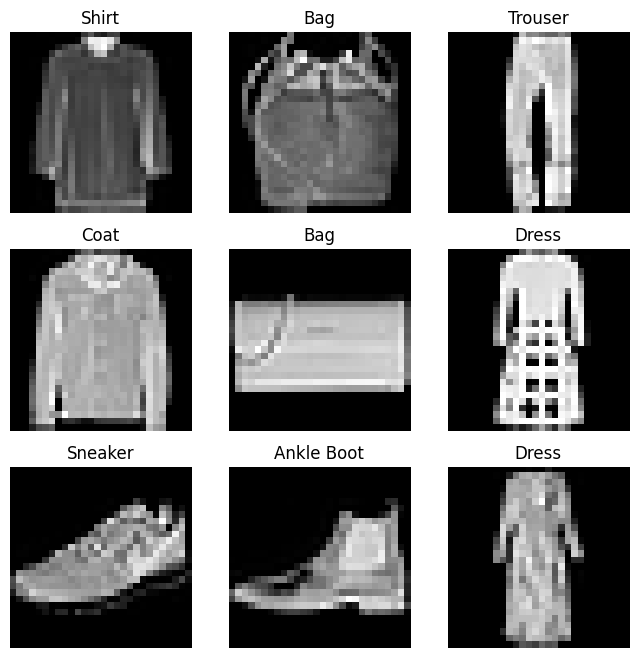

In [26]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

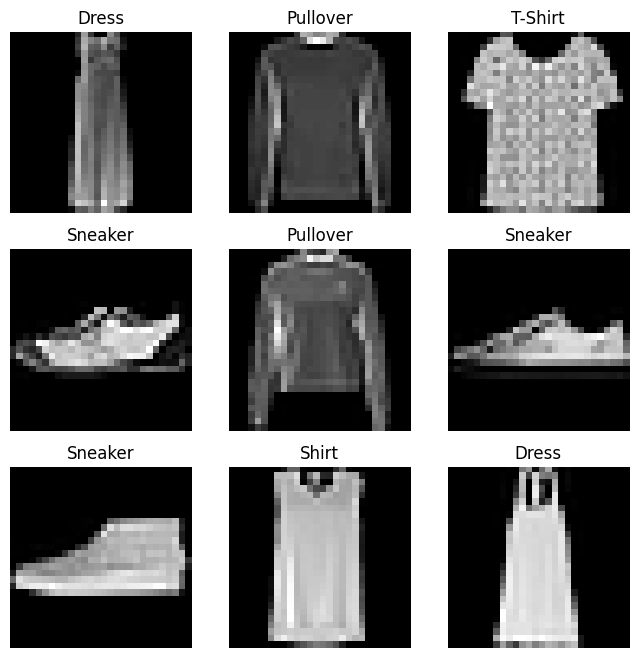

In [28]:
#Test DataSet
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    img, label = test_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [29]:
#Define the neural network architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the neural network
model = MLP()

In [30]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the neural network
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 100, Loss: 0.8943150401115417
Epoch 1, Batch 200, Loss: 0.5856596779823303
Epoch 1, Batch 300, Loss: 0.5302984178066253
Epoch 1, Batch 400, Loss: 0.493035332262516
Epoch 1, Batch 500, Loss: 0.4546979863941669
Epoch 1, Batch 600, Loss: 0.43564113572239876
Epoch 1, Batch 700, Loss: 0.4398683585226536
Epoch 1, Batch 800, Loss: 0.41947924822568894
Epoch 1, Batch 900, Loss: 0.42354237094521524
Epoch 2, Batch 100, Loss: 0.4090692204236984
Epoch 2, Batch 200, Loss: 0.3996918006241322
Epoch 2, Batch 300, Loss: 0.3887489476799965
Epoch 2, Batch 400, Loss: 0.37956555709242823
Epoch 2, Batch 500, Loss: 0.38064905256032944
Epoch 2, Batch 600, Loss: 0.37554051980376246
Epoch 2, Batch 700, Loss: 0.3611651773750782
Epoch 2, Batch 800, Loss: 0.350949135273695
Epoch 2, Batch 900, Loss: 0.36961370199918747
Epoch 3, Batch 100, Loss: 0.3566361239552498
Epoch 3, Batch 200, Loss: 0.3484097756445408
Epoch 3, Batch 300, Loss: 0.34398410230875015
Epoch 3, Batch 400, Loss: 0.34275386452674866
Epo

In [31]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { correct / total}%')

Accuracy on test set: 0.8733%


In [32]:
# Evaluate the model and store predictions
model.eval()
predictions = []
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.numpy())  # Store predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

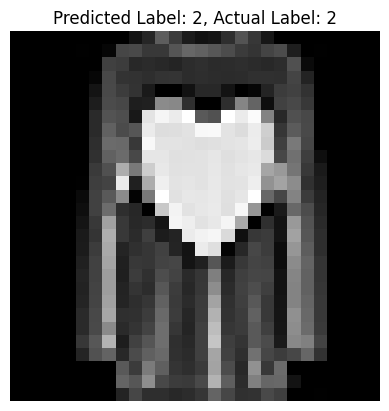

In [33]:
# Get one test image and its label
image, label = images[1], labels[1]

# Reshape the image tensor to a 28x28 shape
image = image.view(28, 28)

# Convert the image tensor to a numpy array for visualization
image_numpy = image.numpy()

# Show the image
plt.imshow(image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predictions[1]}, Actual Label: {label.item()}')
plt.axis('off')
plt.show()
